# Imports

In [1]:
import numpy as np                     
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt       
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.patches as patches
from matplotlib.lines import Line2D

import braingeneers                  
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys
from multiprocessing import Pool
from tqdm import tqdm

# Data

In [2]:
sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')

/tmp/ipykernel_28233/653605344.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')


# Code

In [171]:
bins = 6
angle_bins = np.linspace(0, 2*np.pi, bins+1)

In [172]:
angle_bins

array([0.        , 0.8975979 , 1.7951958 , 2.6927937 , 3.5903916 ,
       4.48798951, 5.38558741])

In [151]:
def calculate_mean_firing_rates(spike_data):
    # Compute mean firing rates for each neuron
    firing_rates = [len(train) / spike_data.length for train in spike_data.train]
    return firing_rates

def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles


def create_reverse_rank_lookup(event_ranks):
    """
    Create a reverse lookup table for event ranks.
    
    Parameters:
    - event_ranks: A dictionary mapping (neuron_id, spike_time) to event rank.
    
    Returns:
    - A dictionary mapping event rank to (neuron_id, spike_time).
    """
    reverse_lookup = {rank: (neuron_id, spike_time) for (neuron_id, spike_time), rank in event_ranks.items()}
    return reverse_lookup 

def calculate_event_ranks(spike_data, precision=5):
    # Flatten the list of spikes, rounding spike times, and sort by time
    # Include the original index of each spike for uniqueness
    all_spikes = [(neuron_id, round(spike_time, precision), idx) 
                  for neuron_id, spikes in enumerate(spike_data.train) 
                  for idx, spike_time in enumerate(spikes)]
                  
    # Sort by neuron_id, then rounded spike time, then original index
    all_spikes_sorted = sorted(all_spikes, key=lambda x: (x[1], x[0], x[2]))
    
    # Generate a dictionary with event rank as key, (neuron_id, spike_time) as value
    ranks = {rank: (neuron_id, spike_time) for rank, (neuron_id, spike_time, _) in enumerate(all_spikes_sorted)}
    
    print(f"Total unique events: {len(ranks)}")
    
    return ranks

def precompute_close_neurons(distances, window_size=17.5):
    close_neurons = {}
    for i in range(len(distances)):
        close_neurons[i] = [j for j in range(len(distances)) if i != j and distances[i, j] < window_size]
    return close_neurons

def compute_bin_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints

In [198]:
def create_histograms_for_events(spike_data, event_ranks, spatial_range=(82, 1092), time_window_rank=30, bins=6):
    total_events = len(event_ranks)

    histograms_for_each_event = {}

    distances = precalculate_distances_angles(get_neuron_positions(spike_data))[0]
    angles = precalculate_distances_angles(get_neuron_positions(spike_data))[1]

    # distance_bins = np.linspace(0, np.max(distances), bins+1)
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)
    angle_bins[-1] += 1e-10  # Make sure the last bin edge is included

    print_every_n = max(total_events // 100, 1)  # Update progress every 10% or at least once
    
    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id + 1}/{total_events}...")
            
        start_rank = max(0, current_event_id - time_window_rank)
        end_rank = min(total_events, current_event_id + time_window_rank + 1)

        event_distances, event_angles = [], []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue

            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            angle = angles[current_neuron_id, other_neuron_id]

            if spatial_range[0] < distance < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)

        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_for_each_event[current_event_id] = {
            'distance': distance_hist,
            'angle': angle_hist
        }
    
    print("Processing complete")
    return histograms_for_each_event

In [199]:
event_ranks = calculate_event_ranks(sd)
histograms = create_histograms_for_events(sd, event_ranks, spatial_range=(82, 1092), time_window_rank=30, bins=6)

Total unique events: 113477
Processing event 1/113477...
Processing event 1135/113477...
Processing event 2269/113477...


/tmp/ipykernel_28233/2426340036.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing event 3403/113477...
Processing event 4537/113477...
Processing event 5671/113477...
Processing event 6805/113477...
Processing event 7939/113477...
Processing event 9073/113477...
Processing event 10207/113477...
Processing event 11341/113477...
Processing event 12475/113477...
Processing event 13609/113477...
Processing event 14743/113477...
Processing event 15877/113477...
Processing event 17011/113477...
Processing event 18145/113477...
Processing event 19279/113477...
Processing event 20413/113477...
Processing event 21547/113477...
Processing event 22681/113477...
Processing event 23815/113477...
Processing event 24949/113477...
Processing event 26083/113477...
Processing event 27217/113477...
Processing event 28351/113477...
Processing event 29485/113477...
Processing event 30619/113477...
Processing event 31753/113477...
Processing event 32887/113477...
Processing event 34021/113477...
Processing event 35155/113477...
Processing event 36289/113477...
Processing event

In [200]:
def apply_sliding_window_average_optimized(spike_data, event_histograms, window_width=17.5, bins=6):
    smoothed_histograms = {}
    event_ranks = calculate_event_ranks(spike_data)
    total_events = len(event_histograms)
    close_neurons = precompute_close_neurons(precalculate_distances_angles(get_neuron_positions(spike_data))[0], window_size=window_width / 2)
    print_every_n = max(total_events // 100, 1)  # Update progress every 10% or at least once
    
    for event_id, histograms in event_histograms.items():
        if event_id % print_every_n == 0:
            print(f"Processing event {event_id + 1}/{total_events}...")
        
        current_neuron_id = event_ranks[event_id][0]
        
        # Initialize summed histogram for the current event
        summed_histogram = {'distance': np.zeros(bins), 'angle': np.zeros(bins)}
        summed_histogram_count = 1  # Start count at 1 to include the current event
        
        # Add the histograms of the current event to the sum
        summed_histogram['distance'] += histograms['distance']
        summed_histogram['angle'] += histograms['angle']

        # Check for close neighbors and add their histograms to the sum
        for neighbor_id in close_neurons.get(current_neuron_id, []):
            if neighbor_id != event_id and neighbor_id in event_histograms:
                neighbor_histograms = event_histograms[neighbor_id]
                summed_histogram['distance'] += neighbor_histograms['distance']
                summed_histogram['angle'] += neighbor_histograms['angle']
                summed_histogram_count += 1

        # Compute the average histogram
        if summed_histogram_count > 0:
            smoothed_histograms[event_id] = {
                'distance': summed_histogram['distance'] / summed_histogram_count,
                'angle': summed_histogram['angle'] / summed_histogram_count
            }
    
    return smoothed_histograms

In [201]:
averaged_histograms = apply_sliding_window_average_optimized(sd, histograms, window_width=17.5, bins=6)

Total unique events: 113477
Processing event 1/113477...
Processing event 1135/113477...
Processing event 2269/113477...
Processing event 3403/113477...
Processing event 4537/113477...
Processing event 5671/113477...
Processing event 6805/113477...
Processing event 7939/113477...
Processing event 9073/113477...
Processing event 10207/113477...
Processing event 11341/113477...
Processing event 12475/113477...
Processing event 13609/113477...
Processing event 14743/113477...
Processing event 15877/113477...
Processing event 17011/113477...
Processing event 18145/113477...
Processing event 19279/113477...
Processing event 20413/113477...
Processing event 21547/113477...
Processing event 22681/113477...
Processing event 23815/113477...
Processing event 24949/113477...
Processing event 26083/113477...
Processing event 27217/113477...
Processing event 28351/113477...
Processing event 29485/113477...
Processing event 30619/113477...
Processing event 31753/113477...
Processing event 32887/1134

/tmp/ipykernel_28233/2426340036.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing event 34021/113477...
Processing event 35155/113477...
Processing event 36289/113477...
Processing event 37423/113477...
Processing event 38557/113477...
Processing event 39691/113477...
Processing event 40825/113477...
Processing event 41959/113477...
Processing event 43093/113477...
Processing event 44227/113477...
Processing event 45361/113477...
Processing event 46495/113477...
Processing event 47629/113477...
Processing event 48763/113477...
Processing event 49897/113477...
Processing event 51031/113477...
Processing event 52165/113477...
Processing event 53299/113477...
Processing event 54433/113477...
Processing event 55567/113477...
Processing event 56701/113477...
Processing event 57835/113477...
Processing event 58969/113477...
Processing event 60103/113477...
Processing event 61237/113477...
Processing event 62371/113477...
Processing event 63505/113477...
Processing event 64639/113477...
Processing event 65773/113477...
Processing event 66907/113477...
Processing

In [81]:
def subtract_average_histograms(spike_data, averaged_histograms, bins=6):
    final_histograms = {}
    window_histograms = apply_sliding_window_average_optimized(spike_data, averaged_histograms, window_width=(336/2), bins=6)
    
    final_histograms = {event_id: {
        'distance': np.round(histograms['distance'] - window_histograms[event_id]['distance'], 3),
        'angle': np.round(histograms['angle'] - window_histograms[event_id]['angle'], 3)
    } for event_id, histograms in averaged_histograms.items()}

    return final_histograms

In [42]:
# final_histograms = subtract_average_histograms(sd, averaged_histograms)

Total unique events: 113477
Processing event 1/113477...
Processing event 1135/113477...
Processing event 2269/113477...
Processing event 3403/113477...
Processing event 4537/113477...
Processing event 5671/113477...
Processing event 6805/113477...
Processing event 7939/113477...
Processing event 9073/113477...
Processing event 10207/113477...
Processing event 11341/113477...
Processing event 12475/113477...
Processing event 13609/113477...
Processing event 14743/113477...
Processing event 15877/113477...
Processing event 17011/113477...
Processing event 18145/113477...
Processing event 19279/113477...
Processing event 20413/113477...
Processing event 21547/113477...
Processing event 22681/113477...
Processing event 23815/113477...
Processing event 24949/113477...


/tmp/ipykernel_600/2324574115.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing event 26083/113477...
Processing event 27217/113477...
Processing event 28351/113477...
Processing event 29485/113477...
Processing event 30619/113477...
Processing event 31753/113477...
Processing event 32887/113477...
Processing event 34021/113477...
Processing event 35155/113477...
Processing event 36289/113477...
Processing event 37423/113477...
Processing event 38557/113477...
Processing event 39691/113477...
Processing event 40825/113477...
Processing event 41959/113477...
Processing event 43093/113477...
Processing event 44227/113477...
Processing event 45361/113477...
Processing event 46495/113477...
Processing event 47629/113477...
Processing event 48763/113477...
Processing event 49897/113477...
Processing event 51031/113477...
Processing event 52165/113477...
Processing event 53299/113477...
Processing event 54433/113477...
Processing event 55567/113477...
Processing event 56701/113477...
Processing event 57835/113477...
Processing event 58969/113477...
Processing

In [202]:
def compute_average_angle_from_histogram(angle_hist):
    # Check if the histogram data is valid
    if len(angle_hist) != 6:
        raise ValueError("The histogram must have 6 bins.")

    # Bin midpoints in degrees
    angle_midpoints_degrees = np.array([30, 90, 150, 210, 270, 330])
    # Convert midpoints to radians for calculations
    angle_midpoints_radians = np.radians(angle_midpoints_degrees)

    # Calculate the vector components of each bin's contribution
    x_components = angle_hist * np.cos(angle_midpoints_radians)
    y_components = angle_hist * np.sin(angle_midpoints_radians)

    # Compute the mean vector components
    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians

def compute_average_distance_angle(final_histograms, bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(82, 1092, bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        # normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

In [203]:
average_distances_angles = compute_average_distance_angle(averaged_histograms, bins=6)

[ 30.  90. 150. 210. 270. 330.]


/tmp/ipykernel_28233/3834219457.py:16: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_28233/3834219457.py:17: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


In [17]:
# def adjust_angles(dist_angle_dict):
#     adjusted_dict = {}
#     for key, value in dist_angle_dict.items():
#         distance = value['distance']
#         angle = value['angle']
#         if distance < 0:
#             angle += np.pi  # Add pi radians if distance is negative
#             angle = angle % (2 * np.pi)  # Normalize angle to [0, 2*pi)
#             distance = abs(distance)
#         adjusted_dict[key] = {'distance': distance, 'angle': angle}
#     return adjusted_dict

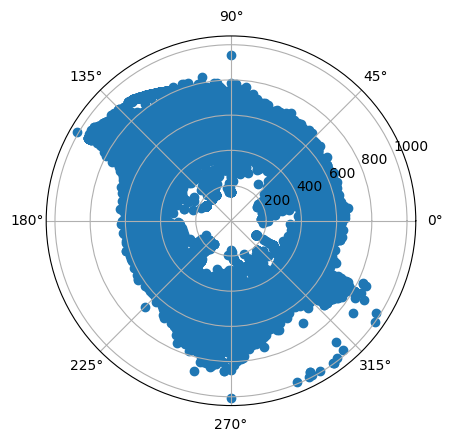

In [204]:
results = average_distances_angles
# Extracting angles and distances

angles = [result['angle'] for result in results.values()]
distances = [result['distance'] for result in results.values()]

# # Convert angles to radians
# angles = np.array(angles)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(angles, distances)

plt.show()

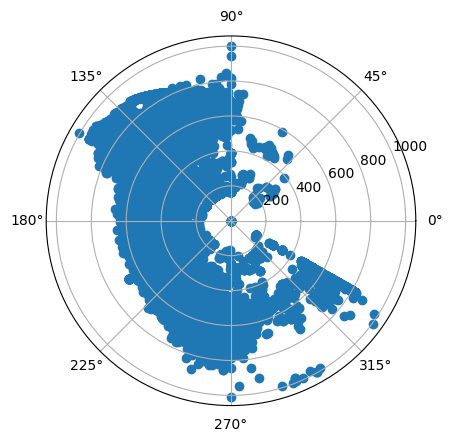

In [128]:
results = average_distances_angles
# Extracting angles and distances

angles = [result['angle'] for result in results.values()]
distances = [result['distance'] for result in results.values()]

# # Convert angles to radians
# angles = np.array(angles)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(angles, distances)

plt.show()

In [89]:
def compute_circular_midpoints(bins):
    edges = np.linspace(0, 2*np.pi, bins+1)
    midpoints = (edges[:-1] + edges[1:]) / 2
    # Adjust the first and last midpoints to handle the circular nature
    midpoints[0] = (edges[0] + edges[1]) / 2
    midpoints[-1] = (edges[-1] + edges[0] + 2*np.pi) / 2 % (2 * np.pi)
    return midpoints

compute_circular_midpoints(6)

array([0.52359878, 1.57079633, 2.61799388, 3.66519143, 4.71238898,
       0.        ])

In [114]:
dist_hist = final_histograms[22]['distance']
distance_midpoints = compute_bin_midpoints(np.linspace(82, 1092, 6+1))
distance_sum = np.sum(dist_hist * distance_midpoints)
distance_count = np.sum(dist_hist)
average_distance = distance_sum / distance_count if distance_count != 0 else 0

print(dist_hist)
print(distance_midpoints)
print(distance_sum)
print(distance_count)
print(average_distance)

[ 2.375  0.25  -2.125  1.5   -2.875 -2.5  ]
[ 166.16666667  334.5         502.83333333  671.16666667  839.5
 1007.83333333]
-4516.645833333334
-3.375
1338.2654320987656


In [109]:
average_distances_angles = compute_average_distance_angle(final_histograms)

In [110]:
average_distances_angles

{0: {'distance': 606.7978060114111, 'angle': 4.77420625398837},
 1: {'distance': 558.9444444444445, 'angle': 3.334497465652324},
 2: {'distance': 434.85125675493765, 'angle': 4.188790204786391},
 3: {'distance': 374.9647435897436, 'angle': 1.6614191918022936},
 4: {'distance': 382.1415094339623, 'angle': 3.0526796539598933},
 5: {'distance': 648.7222222222221, 'angle': 4.572762640225142},
 6: {'distance': 314.3, 'angle': 3.8327430373795472},
 7: {'distance': 322.75581395348837, 'angle': 5.747409815869699},
 8: {'distance': 708.1218050694666, 'angle': 1.9436293079558873},
 9: {'distance': 528.9540229885058, 'angle': 0.12638591135131325},
 10: {'distance': 441.1111111111111, 'angle': 0.6981317007977317},
 11: {'distance': 750.9035087719298, 'angle': 0.9645240603126535},
 12: {'distance': 558.9444444444445, 'angle': 2.7925268031909276},
 13: {'distance': 88.67989417989416, 'angle': 5.460387231239402},
 14: {'distance': 75.5256410256408, 'angle': 4.712388980384693},
 15: {'distance': 495.3

In [97]:
def adjust_angles(dist_angle_dict):
    adjusted_dict = {}
    for key, value in dist_angle_dict.items():
        distance = value['distance']
        angle = value['angle']
        if distance < 0:
            angle += np.pi  # Add pi radians if distance is negative
            angle = angle % (2 * np.pi)  # Normalize angle to [0, 2*pi)
            distance = abs(distance)
        adjusted_dict[key] = {'distance': distance, 'angle': angle}
    return adjusted_dict

In [98]:
adjusted_average_distances_angles = adjust_angles(average_distances_angles)

In [99]:
adjusted_average_distances_angles

{0: {'distance': 606.7978060114111, 'angle': 4.77420625398837},
 1: {'distance': 558.9444444444445, 'angle': 3.334497465652324},
 2: {'distance': 434.85125675493765, 'angle': 4.188790204786391},
 3: {'distance': 374.9647435897436, 'angle': 1.6614191918022936},
 4: {'distance': 382.1415094339623, 'angle': 3.0526796539598933},
 5: {'distance': 648.7222222222221, 'angle': 4.572762640225142},
 6: {'distance': 314.3, 'angle': 3.8327430373795472},
 7: {'distance': 322.75581395348837, 'angle': 5.747409815869699},
 8: {'distance': 708.1218050694666, 'angle': 1.9436293079558873},
 9: {'distance': 528.9540229885058, 'angle': 0.12638591135131325},
 10: {'distance': 441.1111111111111, 'angle': 0.6981317007977317},
 11: {'distance': 750.9035087719298, 'angle': 0.9645240603126535},
 12: {'distance': 558.9444444444445, 'angle': 2.7925268031909276},
 13: {'distance': 88.67989417989416, 'angle': 5.460387231239402},
 14: {'distance': 75.5256410256408, 'angle': 4.712388980384693},
 15: {'distance': 495.3

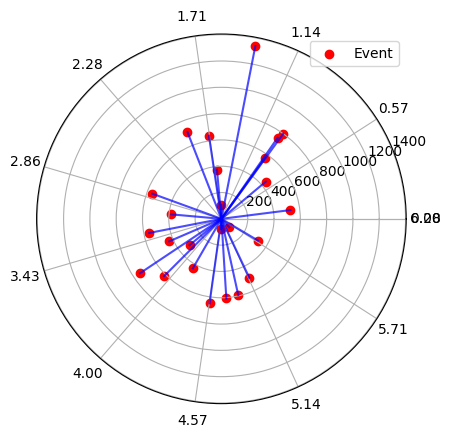

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Your final results
results = {0: {'distance': 606.7978060114111, 'angle': 4.77420625398837},
 1: {'distance': 558.9444444444445, 'angle': 3.334497465652324},
 2: {'distance': 434.85125675493765, 'angle': 4.188790204786391},
 3: {'distance': 374.9647435897436, 'angle': 1.6614191918022936},
 4: {'distance': 382.1415094339623, 'angle': 3.0526796539598933},
 5: {'distance': 648.7222222222221, 'angle': 4.572762640225142},
 6: {'distance': 314.3, 'angle': 3.8327430373795472},
 7: {'distance': 322.75581395348837, 'angle': 5.747409815869699},
 8: {'distance': 708.1218050694666, 'angle': 1.9436293079558873},
 9: {'distance': 528.9540229885058, 'angle': 0.12638591135131325},
 10: {'distance': 441.1111111111111, 'angle': 0.6981317007977317},
 11: {'distance': 750.9035087719298, 'angle': 0.9645240603126535},
 12: {'distance': 558.9444444444445, 'angle': 2.7925268031909276},
 13: {'distance': 88.67989417989416, 'angle': 5.460387231239402},
 14: {'distance': 75.5256410256408, 'angle': 4.712388980384693},
 15: {'distance': 495.34861009266064, 'angle': 5.154585599669973},
 16: {'distance': 107.21906797669946, 'angle': 1.5705607014552436},
 17: {'distance': 639.1547125779873, 'angle': 1.7199258737943275},
 18: {'distance': 616.5833333333333, 'angle': 3.9269908169872387},
 19: {'distance': 432.3518518518519, 'angle': 3.548836145721804},
 20: {'distance': 799.1234301255901, 'angle': 0.9424526623303591},
 21: {'distance': 571.4135802469135, 'angle': 0.9502348149746895},
 22: {'distance': 1338.2654320987656, 'angle': 1.3768708543510826},
 23: {'distance': 744.8125, 'angle': 3.730641276137878},
 24: {'distance': 593.3489042675893, 'angle': 4.929800236688436}}

# Extracting angles and distances
angles = [result['angle'] for result in results.values()]
distances = [result['distance'] for result in results.values()]

# Convert angles to radians
angles = np.array(angles)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot distances as radial lines
for angle, distance in zip(angles, distances):
    ax.plot([angle, angle], [0, distance], color='blue', alpha=0.7)

# Plot points
ax.scatter(angles, distances, color='red', label='Event')

# Set theta ticks to radians
ax.set_xticks(np.linspace(0, 2*np.pi, 12))
ax.set_xticklabels([f'{i:.2f}' for i in np.linspace(0, 2*np.pi, 12)])

# Add legend
ax.legend()

plt.show()